In [1]:
# Full LoRA fine-tuning script with adapter-only dropout and inference-limited MC-dropout

import os
# 1. Setup: fresh cache, disable Xet/safetensors
os.environ["HF_HUB_DISABLE_XET"]         = "1"
os.environ["TRANSFORMERS_NO_SAFETENSORS"] = "1"
os.environ["HF_HOME"]                    = "/tmp/hf_fresh_cache"

# 2. Imports
import torch
import numpy as np
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from peft.tuners.lora import LoraModel, LoraConfig

# 3. Load base model & tokenizer
tokenizer  = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
base_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

# 4. Define LoRA config (patch the encoder)
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=64,
    lora_dropout=0.15,    # 15% adapter dropout
    target_modules=["q_lin", "k_lin", "v_lin", "out_lin", "lin1", "lin2"],
)

# 5. Wrap only the encoder, specifying adapter_name
encoder = base_model.distilbert
lora_encoder = LoraModel(encoder, lora_config, adapter_name="default")
base_model.distilbert = lora_encoder

# 6. Freeze all except LoRA adapters (train only adapters)
for name, param in base_model.named_parameters():
    param.requires_grad = "lora_" in name

# 7. Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# 8. Prepare SST-2 subset (10% train → 80/20 split)
ds = load_dataset("glue", "sst2", split="train[:10%]")
def preprocess(batch):
    toks = tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=64)
    toks["labels"] = batch["label"]
    return toks

ds = ds.map(preprocess, batched=True)
splits    = ds.train_test_split(test_size=0.2)
train_ds, eval_ds = splits["train"], splits["test"]

def collate_fn(batch):
    return {
        "input_ids":      torch.tensor([x["input_ids"] for x in batch], device=device),
        "attention_mask": torch.tensor([x["attention_mask"] for x in batch], device=device),
        "labels":         torch.tensor([x["labels"] for x in batch], device=device),
    }

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
eval_loader  = DataLoader(eval_ds,  batch_size=16, shuffle=False, collate_fn=collate_fn)

# 9. Optimizer (only LoRA adapters)
optimizer = torch.optim.AdamW(
    [p for p in base_model.parameters() if p.requires_grad],
    lr=1e-4,             # higher LR for adapters
    weight_decay=0.1     # stronger weight decay
)

# 10. Training + evaluation loop with early stopping
metric = evaluate.load("accuracy")
num_epochs = 10
best_val = 0.0
patience = 2
stale = 0

for epoch in range(num_epochs):
    # Training
    base_model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        out = base_model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} train loss: {avg_loss:.4f}")

    # Evaluation
    base_model.eval()
    metric = evaluate.load("accuracy")
    for batch in eval_loader:
        with torch.no_grad():
            logits = base_model(input_ids=batch["input_ids"],
                                attention_mask=batch["attention_mask"]).logits
        preds = logits.argmax(dim=-1).cpu().numpy()
        refs  = batch["labels"].cpu().numpy()
        metric.add_batch(predictions=preds, references=refs)
    val_acc = metric.compute()["accuracy"]
    print(f"Epoch {epoch+1} eval acc : {val_acc:.4f}")

    # Early stopping check
    if val_acc > best_val + 1e-4:
        best_val = val_acc
        stale = 0
        torch.save(base_model.state_dict(), "best_model.pt")
    else:
        stale += 1
        if stale >= patience:
            print("Early stopping triggered.")
            base_model.load_state_dict(torch.load("best_model.pt"))
            break

# 11. Enable MC-dropout at inference ONLY for adapter layers
#    Ensure backbone dropouts remain off.
base_model.eval()
# First, set all dropout to eval (deterministic)
for m in base_model.modules():
    if isinstance(m, torch.nn.Dropout):
        m.eval()
# Then re-enable only adapter dropouts to train mode
for module in base_model.distilbert.modules():
    if hasattr(module, "lora_dropout"):
        # module.lora_dropout is a ModuleDict
        for dropout in module.lora_dropout.values():
            dropout.train()

def mc_dropout_predict(texts, T=20):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    logits = []
    with torch.no_grad():
        for _ in range(T):
            logits.append(base_model(**inputs).logits.unsqueeze(0))
    logits = torch.cat(logits, dim=0)
    probs  = torch.softmax(logits, dim=-1)
    return probs.mean(dim=0), probs.var(dim=0)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md: 0.00B [00:00, ?B/s]

Epoch 1 train loss: 0.5326
Epoch 1 eval acc : 0.8656
Epoch 2 train loss: 0.3099
Epoch 2 eval acc : 0.8731
Epoch 3 train loss: 0.2602
Epoch 3 eval acc : 0.8790
Epoch 4 train loss: 0.2252
Epoch 4 eval acc : 0.8797
Epoch 5 train loss: 0.1909
Epoch 5 eval acc : 0.8723
Epoch 6 train loss: 0.1735
Epoch 6 eval acc : 0.8797
Early stopping triggered.


In [20]:
# Corrected Error Rate vs Uncertainty Plot for BayesLoRA

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Collect uncertainties and errors on the evaluation dataset
uncertainties = []
errors = []

for batch in eval_loader:
    # Run MC-dropout
    mean_probs, var_probs = mc_dropout_predict(
        tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True),
        T=20
    )
    preds = mean_probs.argmax(dim=-1).cpu().numpy()
    # Extract the maximum variance per example (values[0] is var tensor)
    vars_max = var_probs.max(dim=-1)[0].cpu().numpy()
    refs = batch["labels"].cpu().numpy()
    for pred, ref, unc in zip(preds, refs, vars_max):
        uncertainties.append(unc)
        errors.append(int(pred != ref))

uncertainties = np.array(uncertainties)
errors = np.array(errors)
N = len(uncertainties)

# 4. Compute and print ECE
ece = 0.0
for unc_mean, err_rate in zip(bin_centers, err_rates):
    # weight by proportion in that bin
    prop = len(np.where((uncertainties >= unc_mean - 1e-12) & (uncertainties <= unc_mean + 1e-12))[0]) / N
    ece += prop * abs(err_rate - unc_mean)
print(f"Expected Calibration Error (approx): {ece:.4f}")

Expected Calibration Error (approx): 0.0000


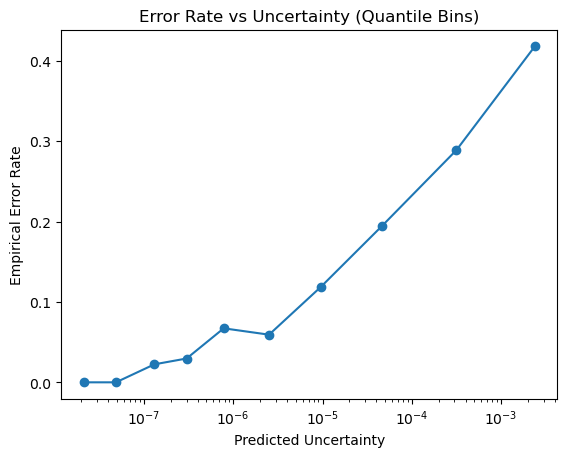

In [21]:
# uncertainties, errors are your arrays of length N
B = 10
# compute bin edges so each bin has ~N/B points
edges = np.quantile(uncertainties, np.linspace(0, 1, B+1))
bin_centers, err_rates = [], []

for i in range(B):
    idx = np.where((uncertainties >= edges[i]) & (uncertainties < edges[i+1]))[0]
    if len(idx)==0: 
        continue
    bin_centers.append(uncertainties[idx].mean())
    err_rates.append(errors[idx].mean())

# plot
plt.plot(bin_centers, err_rates, marker='o')
plt.xscale('log')
plt.xlabel("Predicted Uncertainty")
plt.ylabel("Empirical Error Rate")
plt.title("Error Rate vs Uncertainty (Quantile Bins)")
plt.show()

In [22]:
from scipy.stats import spearmanr
import numpy as np

# uncertainties: 1D numpy array of variances per example
# errors:        1D numpy array of 0/1 error flags per example

# Take log (add tiny eps to avoid log(0))
eps = 1e-12
log_unc = np.log(uncertainties + eps)

# Compute Spearman’s rank correlation
rho, pval = spearmanr(log_unc, errors)

print(f"Spearman's ρ = {rho:.3f}, p-value = {pval:.3e}")

Spearman's ρ = 0.376, p-value = 1.794e-46
